# Essential Libraries

In [161]:
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2, csv
import pandas as pd
import numpy as np
import random
import splitfolders
import shutil
import os
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv3D, MaxPooling2D, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")

print("Path to dataset files:", path) # <== This is the path to the dataset files

### Cleaning & Pre-processing

In [42]:
# ImagesDir = "/Users/muhammadabdelmohsen/Desktop/MasterML/DogBreedsClassification/Images"
# # Split the dataset into train, validation, and test sets
# trainDir = "/Users/muhammadabdelmohsen/Desktop/MasterML/DogBreedsClassification/train"
# testDir = "/Users/muhammadabdelmohsen/Desktop/MasterML/DogBreedsClassification/test"
# valDir = "/Users/muhammadabdelmohsen/Desktop/MasterML/DogBreedsClassification/val"

In [53]:
ImagesDir = "/Users/muhammadabdelmohsen/Desktop/MasterML/DogBreedsClassification/dog-breeds"
# Split the dataset into train, validation, and test sets
trainDir = "/Users/muhammadabdelmohsen/Desktop/MasterML/DogBreedsClassification/dog-breeds/1/train"
testDir = "/Users/muhammadabdelmohsen/Desktop/MasterML/DogBreedsClassification/dog-breeds/1/test"
valDir = "/Users/muhammadabdelmohsen/Desktop/MasterML/DogBreedsClassification/dog-breeds/1/val"

# Remove the IDs

In [46]:
for i in os.listdir(ImagesDir):
    if i == ".DS_Store":
        continue
    name = i.split('-', 1)[0]   # Split at first dash and take the second part
    print(name)


rottweiler
dalmatian
german
beagle
husky
poodle
bulldog
labrador


In [209]:
Folders = set(os.listdir(ImagesDir))
print("Unique Dog Breeds Found:", len(Folders) )

Folders

Unique Dog Breeds Found: 10


{'.DS_Store',
 '1',
 'beagle',
 'bulldog',
 'dalmatian',
 'german-shepherd',
 'husky',
 'labrador-retriever',
 'poodle',
 'rottweiler'}

In [49]:
# add all the folders in the foldersSet to the trainDir, testDir, valDir
if not os.path.exists(trainDir):
    os.makedirs(trainDir)
if not os.path.exists(testDir):
    os.makedirs(testDir)
if not os.path.exists(valDir):
    os.makedirs(valDir)
# Create subdirectories for train, test, and validation sets dog breeds
for folder in Folders:

    if folder == ".DS_Store":
        continue
    folderPath = os.path.join(ImagesDir, folder)
    if not os.path.exists(os.path.join(trainDir, folder)):
        os.makedirs(os.path.join(trainDir, folder))
    if not os.path.exists(os.path.join(testDir, folder)):
        os.makedirs(os.path.join(testDir, folder))
    if not os.path.exists(os.path.join(valDir, folder)):
        os.makedirs(os.path.join(valDir, folder))


In [51]:
random.seed(42)

for breed in os.listdir(ImagesDir):
    breed_path = os.path.join(ImagesDir, breed)
    if breed == ".DS_Store" or breed == "1":
        continue

    images = [f for f in os.listdir(breed_path) if os.path.isfile(os.path.join(breed_path, f))]
    random.shuffle(images)
    percent = 1

    nTotal = int(percent*len(images))
    nTrain = int(0.8 * nTotal)
    nVal = int(0.1 * nTotal)
    nTest = nTotal - nTrain - nVal

    selected_images = images[:nTotal]
    train_files = selected_images[:nTrain]
    val_files = selected_images[nTrain:nTrain + nVal]
    test_files = selected_images[nTrain + nVal:]

    for split_name, split_files in zip(
        ["train", "val", "test"],
        [train_files, val_files, test_files]
    ):
        split_breed_dir = os.path.join(ImagesDir,"1", split_name, breed)
        os.makedirs(split_breed_dir, exist_ok=True)

        for file in split_files:
            src = os.path.join(breed_path, file)
            dst = os.path.join(split_breed_dir, file)
            shutil.copy2(src, dst)

    print(f"Breed: {breed} -> Train: {nTrain}, Val: {nVal}, Test: {nTest}")

print("✅ Done splitting!")

Breed: rottweiler -> Train: 62, Val: 7, Test: 9
Breed: dalmatian -> Train: 40, Val: 5, Test: 6
Breed: german-shepherd -> Train: 60, Val: 7, Test: 9
Breed: beagle -> Train: 66, Val: 8, Test: 9
Breed: husky -> Train: 56, Val: 7, Test: 8
Breed: poodle -> Train: 44, Val: 5, Test: 7
Breed: bulldog -> Train: 60, Val: 7, Test: 9
Breed: labrador-retriever -> Train: 40, Val: 5, Test: 5
✅ Done splitting!


In [54]:
cnt=0
for i in os.listdir(testDir):
    if i == ".DS_Store":
        continue
    for x in os.listdir(os.path.join(testDir, i)):
        cnt=cnt+1
print("Total number of images in test set:", cnt)

Total number of images in test set: 62


# Data Augmentation

In [143]:
trainData = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    fill_mode='nearest'
)
testData = ImageDataGenerator(rescale=1./255)
valData = ImageDataGenerator(rescale=1./255)

In [ ]:
trainData = trainData.flow_from_directory(
    trainDir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=128,
    class_mode='categorical',
    shuffle=True
)

testData = testData.flow_from_directory(
    testDir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=128,
    class_mode='categorical',
    shuffle=True
)

valData = valData.flow_from_directory(
    valDir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=128,
    class_mode='categorical',
    shuffle=True
)

Found 428 images belonging to 8 classes.
Found 62 images belonging to 8 classes.
Found 51 images belonging to 8 classes.


In [ ]:
# import os
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.preprocessing.image import load_img, img_to_array

# def load_dataset(directory, image_size=(224, 224)):
#     images = []
#     labels = []
#     class_names = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
#     class_to_idx = {name: idx for idx, name in enumerate(class_names)}

#     for class_name in class_names:
#         class_dir = os.path.join(directory, class_name)
#         for fname in os.listdir(class_dir):
#             if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
#                 img_path = os.path.join(class_dir, fname)
#                 img = load_img(img_path, target_size=image_size)
#                 img_array = img_to_array(img) / 255.0  # normalize
#                 images.append(img_array)
#                 labels.append(class_to_idx[class_name])

#     images = np.array(images, dtype=np.float32)
#     labels = to_categorical(np.array(labels), num_classes=len(class_names))
#     return images, labels, class_names

# # Load datasets manually
# x_train, y_train, class_names = load_dataset(trainDir)
# x_val, y_val, _ = load_dataset(valDir)
# x_test, y_test, _ = load_dataset(testDir)

# # Wrap in tf.data.Dataset
# trainData = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1000).batch(32)
# valData = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(32)
# testData = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# print("✅ Manually loaded datasets")
# print("Classes:", class_names)
# print("Train:", x_train.shape, y_train.shape)
# print("Val:", x_val.shape, y_val.shape)
# print("Test:", x_test.shape, y_test.shape)


✅ Manually loaded datasets
Classes: ['beagle', 'bulldog', 'dalmatian', 'german-shepherd', 'husky', 'labrador-retriever', 'poodle', 'rottweiler']
Train: (428, 224, 224, 3) (428, 8)
Val: (51, 224, 224, 3) (51, 8)
Test: (62, 224, 224, 3) (62, 8)


In [145]:
print("Number of classes:", trainData.num_classes)
print("Class indices:", trainData.class_indices)
print("Samples per class:", trainData.samples)

Number of classes: 8
Class indices: {'beagle': 0, 'bulldog': 1, 'dalmatian': 2, 'german-shepherd': 3, 'husky': 4, 'labrador-retriever': 5, 'poodle': 6, 'rottweiler': 7}
Samples per class: 428


In [109]:
# for i in testData:
#     plt.imshow(i[0][0])
#     plt.title(i[1][0])
#     plt.axis('off')

#     plt.show()

In [60]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [61]:
for layer in base_model.layers:
    layer.trainable = False

In [62]:
x_batch, y_batch = next(iter(trainData))
print(x_batch.shape, y_batch.shape)


(32, 224, 224, 3) (32, 8)


In [158]:
model = Sequential()

model.add(Conv2D(64, (3,3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dense(8, activation='softmax'))


In [159]:
earlyStopping = EarlyStopping(patience = 5, restore_best_weights=True, monitor='val_loss')
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [160]:
history = model.fit(
    trainData,
    validation_data=valData,
    epochs=15,
    callbacks=[earlyStopping],
    verbose=1
)

Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.1554 - loss: 2.2852 - val_accuracy: 0.2157 - val_loss: 2.0525
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.1348 - loss: 2.0475 - val_accuracy: 0.2157 - val_loss: 2.0061
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.2286 - loss: 1.9863 - val_accuracy: 0.2745 - val_loss: 1.8272
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.3840 - loss: 1.7867 - val_accuracy: 0.3922 - val_loss: 1.5946
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.4927 - loss: 1.4687 - val_accuracy: 0.4902 - val_loss: 1.3744
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.5865 - loss: 1.1986 - val_accuracy: 0.6275 - val_loss: 1.1168
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.6271 - loss: 1.0551 - val_accuracy: 0.6667 - val_loss: 0.9365
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.6919 - loss: 0.9843 - val_accuracy: 0.6471 - val_loss:

In [166]:
weights_path = "/Users/muhammadabdelmohsen/Desktop/MasterML/DogBreedsClassification/dog_breeds_weights"
if not os.path.exists(os.path.dirname(weights_path)):
    os.makedirs(os.path.dirname(weights_path))
model.save(os.path.join(weights_path, "model.keras"))

In [167]:
for i in history.history:
    print(i, ":", history.history[i][-1])

accuracy : 0.8714953064918518
loss : 0.4034431278705597
val_accuracy : 0.8235294222831726
val_loss : 0.6161123514175415


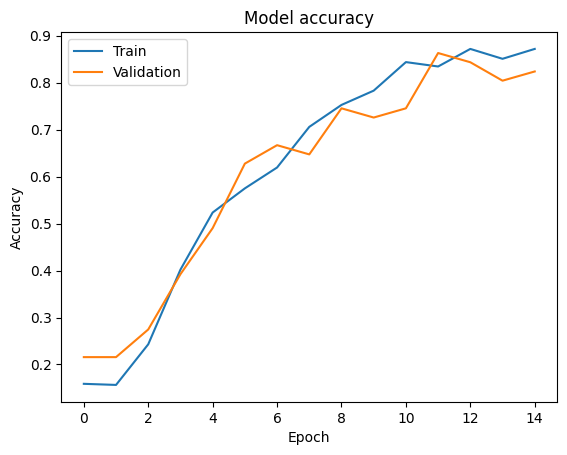

In [179]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


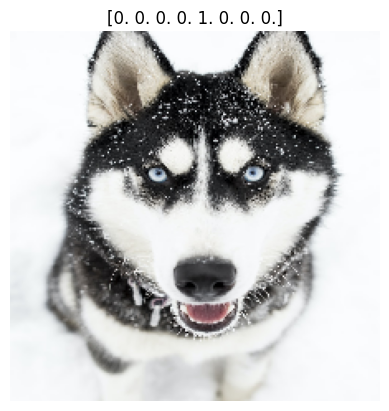

Predicted: 4
Actual: 4


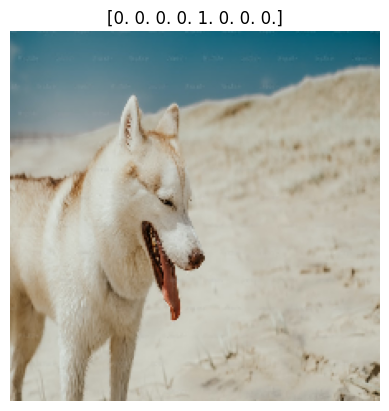

Predicted: 4
Actual: 4


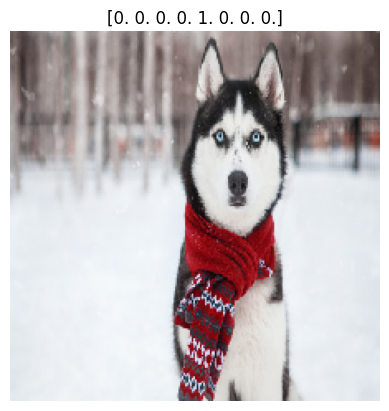

Predicted: 4
Actual: 4


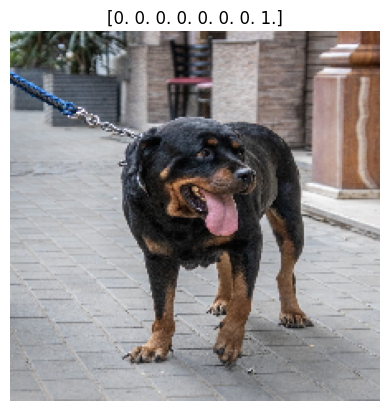

Predicted: 7
Actual: 7


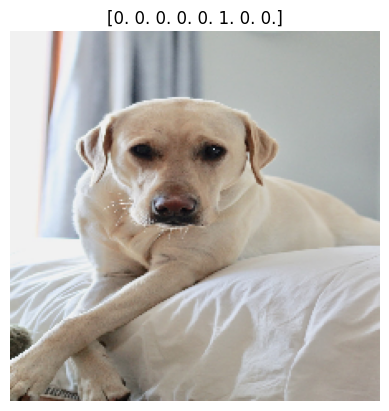

Predicted: 6
Actual: 5


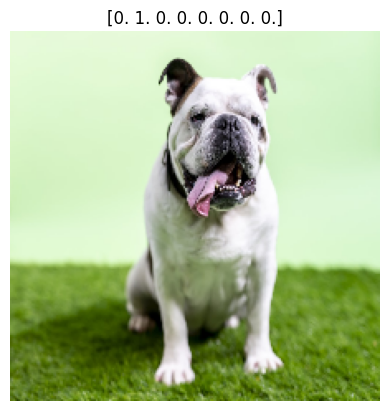

Predicted: 1
Actual: 1


In [208]:
cnt = 0
for i in testData:
    images, labels = i
    preds = model.predict(images)
    for j, image in enumerate(images):
        plt.imshow(image)
        plt.title(labels[j])
        plt.axis('off')
        plt.show()
        print("Predicted:", np.argmax(preds[j]))
        print("Actual:", np.argmax(labels[j]))
        cnt = cnt + 1
        if cnt > 5:
            break
    cnt += 1
    if cnt > 5:
        break
